# Charge




## Libraries and setup  

In [4]:
import math
import pandas as pd
import sys
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
#import pdb2table

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width',None)
pd.set_option('display.max_colwidth',None)

## Data folder and PDB accessions

In [5]:
srt_i =0#srt_i=int(sys.argv[1])
stp_i = 999999 #stp_i=int(sys.argv[2])
data_dir = "../data"
with open("../data/pdb_list.txt", encoding="utf-8") as f:
    read_data = f.read()
    pdb_list = read_data.split('\n')

print("number of pdbs = %s"%len(pdb_list))

if stp_i < len(pdb_list):
    pdb_list = pdb_list[srt_i:stp_i]
else:
    pdb_list = pdb_list[srt_i:]
    stp_i=len(pdb_list)
print("number of pdbs = %s"%len(pdb_list))
print(pdb_list[:10])

number of pdbs = 22268
number of pdbs = 22268
['121p_A', '13pk_A', '13pk_B', '13pk_C', '13pk_D', '1a0c_A', '1a0c_B', '1a0c_C', '1a0c_D', '1a0d_A']


# Parse PDB files in data folder

## Function 1: split_ATOM


**split_ATOM()** takes a PDB ATOM record as input and returns a tuple containing the following information:

- serial number (6-11 characters)
- Atom name (11-16 characters)
- Residue name (16th character)
- Residue sequence number (17-20 characters)
- X-coordinate (21-26 characters)
- Y-coordinate (27-30 characters)
- Z-coordinate (31-36 characters)
- Occupancy (37-41 characters)
- Temperature factor (42-46 characters)
- Element symbol (46-53 characters)
- Charge (54-59 characters)
- Radius (60-65 characters)
- Segment identifier (72-75 characters)
- TER flag (76-78 characters)
- Unknown field (79-80 characters)

This function allows to extract the values in PDB files. The function works by splitting the ATOM record into 14 columns, each containing a single piece of information. The function then removes all whitespace from each column and returns the tuple of columns.

In [6]:
def split_ATOM(raw):
    return(raw.str[6:11].str.replace(' ', ''),  
           raw.str[11:16].str.replace(' ', ''),
           raw.str[16].str.replace(' ', ''),
           raw.str[17:20].str.replace(' ', ''), 
           raw.str[21].str.replace(' ', ''),
           raw.str[22:26].str.replace(' ', ''),
           raw.str[27].str.replace(' ', ''),
           raw.str[30:37].str.replace(' ', ''),
           raw.str[38:45].str.replace(' ', ''),
           raw.str[46:53].str.replace(' ', ''),
           raw.str[54:59].str.replace(' ', ''),
           raw.str[60:65].str.replace(' ', ''),
           raw.str[72:75].str.replace(' ', ''),
           raw.str[76:78].str.replace(' ', ''),
           raw.str[79:].str.replace(' ', ''))


## Function 2: get_ATOM_DF

'ATOM' and 'HETATM' use get_ATOM_DF for a atom level dataframe


In [7]:
def get_ATOM_DF(ATOM, pdb=None):
    atom_data = split_ATOM(ATOM['raw'])
    ATOM = pd.DataFrame({
         'serial':atom_data[0],
         'atom_name':atom_data[1],
         'altLoc':atom_data[2],
         'resName':atom_data[3],
         'chainID':atom_data[4],
         'resNum':atom_data[5],
         'iCode':atom_data[6],
         'x':atom_data[7],
         'y':atom_data[8],
         'z':atom_data[9],
         'occupancy':atom_data[10],
         'tempFactor':atom_data[11],
         'segID':atom_data[12],
         'element':atom_data[13],
         'charge':atom_data[14] })
    # change coordinates to float to make them usable
    ATOM['x']=ATOM['x'].astype(float)
    ATOM['y']=ATOM['y'].astype(float)
    ATOM['z']=ATOM['z'].astype(float)
    return(ATOM)

## Function3: get_struc_atom_coords

**get_struc_atom_coords()** takes the full path to a PDB file as input and returns a DataFrame containing the atomic coordinates for all atoms in the structure.

The function works as follows:

- It opens the PDB file and reads all of the lines into a list.
- It then creates a pandas DataFrame from the list of lines, with each line representing a single record in the PDB file.
- It uses the str[:80] slice operator to extract the first 80 characters from each record. This is because the first 80 characters of a PDB record contain all of the information necessary to extract the atomic coordinates.
- It then uses the str[:6].str.replace(' ', '') slice operator and string replacement function to extract the type of record from each record. - This is necessary to distinguish between ATOM and HETATM records.
- It then uses the pdb_file_df[pdb_file_df['key'] == 'ATOM'] filter to select all of the ATOM records from the DataFrame.
- It then calls the get_ATOM_DF() function to extract the atomic coordinates from the ATOM records.
- If there are any HETATM records in the PDB file, the function calls the get_ATOM_DF() function to extract the atomic coordinates from those records as well.
- Finally, the function concatenates the atomic coordinates from the ATOM and HETATM records into a single DataFrame and returns the DataFrame.

The get_ATOM_DF() function is a helper function that extracts the atomic coordinates from a single ATOM or HETATM record. The function works by splitting the record into 14 columns, each containing a single piece of information. The function then extracts the X, Y, and Z coordinates from the 14 columns and returns them as a NumPy array.

In [8]:
def get_struc_atom_coords(fullpath2pdbfile):
    f = open(fullpath2pdbfile, "r")
    pdb_lines = f.readlines()
    pdb_file_df = pd.DataFrame(pdb_lines, columns = ['raw'])
    pdb_file_df['raw'] = pdb_file_df['raw'].str[:80]
    pdb_file_df['key'] = pdb_file_df['raw'].str[:6].str.replace(' ', '')
    ## only keep first model, mostly for NMR models
    atom_coords = get_ATOM_DF(pdb_file_df[pdb_file_df['key'] == 'ATOM'])
    if len(pdb_file_df[pdb_file_df['key'] == 'HETATM'])>0:
        hetatm_coords = get_ATOM_DF(pdb_file_df[pdb_file_df['key'] == 'HETATM'])
        atom_coords = pd.concat([atom_coords, hetatm_coords], ignore_index=True)
    #atom_coords.reset_index(drop=True, inplace=True)
    return(atom_coords)


## Function 4: Obtain charge values and merge with location

In [9]:
def solvnrg(slvnrg_file):
     with open(slvnrg_file, 'r') as f:
          data = f.read()
     lines = data.split('\n')
     df = pd.DataFrame([line.split() for line in lines if line.startswith('SOLV')],
                    columns=['c1', 'c2', 'c3', 'atom', 'res', 'resNum', 'charge', 'solv_nrg'])
     df['charge'] = df['charge'].astype(float)
     return df[['atom', 'res', 'resNum', 'charge']]

def charge_res(nrg_file):
     nrg_res = nrg_file.groupby(['resNum', 'res'])[['charge']].sum().round(3)
     nrg_res.reset_index(inplace=True)
     return nrg_res

In [40]:
METAL_RES_CODES= [ "FE" ,"FE2","FES","FEO", "CU" ,"CU1","CUA","MG" ,"ZN" ,"MN","MO" ,"MOO","MOS","NI" ,"3CO","CO"]

# Get charge vectors and magnitudes for each metal sites in a single protein 
def get_charge_protein(charge_residues):
    charge_prot = charge_residues.groupby(['pdb', 'metal_num', 'metal_name'])[['charge','qx', 'qy', 'qz']].sum().round(5)
    charge_prot.reset_index(inplace=True)
    charge_prot["qt"] = 0.0
    df_charge = []
    for i, row in charge_prot.iterrows():
        row['qt'] = math.sqrt(row['qx']**2 + row['qy']**2 + row['qz']**2)
        if row['charge'] >= 0:
            row['qt'] = abs(row['qt'])
        else: 
            row['qt'] = -abs(row['qt'])
        irow = pd.DataFrame(row)
        df_charge.append(irow)
    df_charge = pd.concat(df_charge, axis=1).T
    return df_charge

# Generate a metal site or a cluster of metals


# Get vectors of charge for residues 
def get_charge_vectors(this_data_dir, this_struc_id, metal_maxdist):
    this_struc_file = "%s/%s_Rlx.pdb"%(this_data_dir, this_struc_id)
    slvnrg_file = "%s/%s_bluues.solv_nrg"%(this_data_dir, this_struc_id)

    # data from pdb and from solvation_energy
    df_pdb = get_struc_atom_coords(this_struc_file)
    df_slvnrg = solvnrg(slvnrg_file)
    df_slvnrg["charge"] = df_slvnrg["charge"].astype(float)
    df_slvnrg = charge_res(df_slvnrg)

    #merge solvation energy values
    atoms = df_pdb.loc[(~df_pdb["atom_name"].isin(METAL_RES_CODES)) & (df_pdb["atom_name"]=='C')]
    atoms = atoms.merge(df_slvnrg.set_index('resNum'), how='left', on='resNum', suffixes=('', '_y'))
    atoms = atoms.drop('charge', axis=1)
    atoms = atoms.rename(columns={'charge_y': 'charge'})
    
    #Select metal ions 
    metals = df_pdb.loc[df_pdb["atom_name"].isin(METAL_RES_CODES)]
    for mi, mr in mah2_sites.iterrows():
        metals_row = mr[['pdb_name', 'seqNum1', 'seqNum2', 'seqNum3', 'seqNum4']]
        metals_list = metals_row[['seqNum1', 'seqNum2', 'seqNum3', 'seqNum4']].values.tolist()
        mets_row = metals.loc[(metals["resNum"].isin(metals_list))&(metals["resName"]==metals_row["pdb_name"])]
        #print(metals_row, mets_row.head(1))


    # Create table of data for atoms and residues
    atoms['pdb'] = this_struc_id
    atoms['metal_name'] = ""
    atoms['metal_num'] = 0
    atoms['metal_dist'] = 10000
    atoms['ax'] = 0; atoms['ay'] = 0; atoms['az'] = 0
    atoms['ux'] = 0; atoms['uy'] = 0; atoms['uz'] = 0
    atoms['qx'] = 0; atoms['qy'] = 0; atoms['qz'] = 0
    df_atoms = []
    if len(metals)>0:
        for mindex, mrow in metals.iterrows():
            for index, row in atoms.iterrows():
                row['metal_dist'] = math.sqrt((mrow['x']-row['x'])**2 + (mrow['y']-row['y'])**2 + ((mrow['z']-row['z'])**2))
                row['ax'] = row['x']-mrow['x']; row['ux'] = row['ax']/row['metal_dist']
                row['ay'] = row['y']-mrow['y']; row['uy'] = row['ay']/row['metal_dist']
                row['az'] = row['z']-mrow['z']; row['uz'] = row['az']/row['metal_dist']
                row['metal_name']= mrow['resName']
                row['metal_num']= mrow['resNum']
                row['qx'] = row['charge']*abs(row['ux']/(row['metal_dist']))
                row['qy'] = row['charge']*abs(row['uy']/(row['metal_dist']))
                row['qz'] = row['charge']*abs(row['uz']/(row['metal_dist']))
                irow = pd.DataFrame(row)
                df_atoms.append(irow)
    df_atoms = pd.concat(df_atoms, axis=1).T
    df_atoms = df_atoms.loc[df_atoms['metal_dist'] <= metal_maxdist].copy().reset_index(drop=True)
    #print(this_struc_id, ":", df_atoms.shape)
    df_charge = get_charge_protein(df_atoms)
    return (df_charge, df_atoms)

### Metal sites from MAHOMES II

In [41]:
mah2_sites = pd.read_csv('../results/sites2.csv', header=0, keep_default_na=False)
mah2_sites["pdb_uniq"] = mah2_sites['pdb_name'].astype(str) + "_" + mah2_sites['resName1'].astype(str) + "_" + mah2_sites['seqNum1'].astype(str)
mah2_sites = mah2_sites.drop_duplicates(subset=['pdb_uniq'])
#mah2_sites.drop(['pdb_uniq'], axis=1, inplace=True)
mah2_sites = mah2_sites.sort_values(by=['pdb_name'])
mah2_sites = mah2_sites.loc[:, ['pdb_name', 'resName1', 'resName2', 'resName3', 'resName4', 
                        'seqNum1', 'seqNum2', 'seqNum3', 'seqNum4', 'n_metals', 'pdb_uniq']]
print(mah2_sites.shape)
mah2_sites.head(1)

(4051, 11)


,pdb_name,resName1,resName2,resName3,resName4,seqNum1,seqNum2,seqNum3,seqNum4,n_metals,pdb_uniq
2548,13pk_A,MG,,,,422,,,,1,13pk_A_MG_422


In [105]:
for i in range(mah2_sites.shape[0]):
    metals_row = mah2_sites.iloc[i,5:9].values.tolist()

## Function 5: get_charges_4all_structs

In [42]:
df2 = pd.read_csv('../results/sites2.csv', header=0)
#df2["pdb_uniq"] = df2['pdb_name'].astype(str) + "_" + df2['resName1'].astype(str) + "_" + df2['seqNum1'].astype(str)
df2 = df2.drop_duplicates(subset=['pdb_name'])
df2 = df2.sort_values(by=['pdb_name'])
df_mah2 = df2.loc[:, [ 'pdb_name', 'resName1', 'resName2', 'resName3', 
                        'resName4', 'seqNum1', 'seqNum2', 'seqNum3', 'seqNum4']]
print(df2.columns)
print(df2.shape)
pdb_list = df_mah2['pdb_name'].tolist()
print(pdb_list[:10], ", ...... ")

Index(['struc_id', 'resName1', 'seqNum1', 'SITE_ID', 'nuclearity', 'resName2',
       'seqNum2', 'resName3', 'seqNum3', 'resName4', 'seqNum4', 'Set',
       'pdb_name', 'MAHOMES_match', 'Enzyme', 'meta_site', 'n_metals'],
      dtype='object')
(3013, 17)
['13pk_A', '1a0e_A', '1a3x_B', '1a65_A', '1a7i_A', '1aaf_A', '1ad4_A', '1af6_A', '1ag0_A', '1ah7_A'] , ...... 


In [43]:
def get_charges_4all_structs(data_directory, struc_list):
    all_charge_vctrs = []
    all_prot_chrgs = []
    i=1
    for struc in struc_list:
        try:
          prot_chrg, prot_chrg_vecs = get_charge_vectors("%s/%s/%s/%s"%(data_directory, struc[0], struc[1], struc), struc, 15)
          all_charge_vctrs.append(prot_chrg_vecs)
          all_prot_chrgs.append(prot_chrg)
          print(i,": ", struc, ":", prot_chrg_vecs.shape)
        except:
            print(i, "failed to add LBHB for %s"%(struc))
        i += 1
    all_charge_vctrs = pd.concat(all_charge_vctrs, ignore_index=True)
    all_prot_chrgs = pd.concat(all_prot_chrgs, ignore_index=True)
    print("Run done")
    return(all_charge_vctrs, all_prot_chrgs)


In [44]:
#Example to obtain 5 last metal sites
 
data_directory = '../data'
pdbs_list = pdb_list[3008:len(pdb_list)]
all_charge_vctrs, all_prot_chrgs = get_charges_4all_structs(data_directory, pdbs_list)
#all_charge_vctrs.to_csv("../results/charges_residues.csv")
#all_prot_chrgs.to_csv("../results/charges_proteins.csv")
all_prot_chrgs.head(6)

1 failed to add LBHB for 6y1j_A
2 failed to add LBHB for 6y2c_A
3 failed to add LBHB for 6yih_A
4 failed to add LBHB for 7bu2_A
5 failed to add LBHB for 7mdh_A


ValueError: No objects to concatenate

In [92]:
# Run for all metal sites from MAHOMES II
data_directory = '../data'
pdbs_list = pdb_list#[4000:len(pdb_list)-2]
all_charge_vctrs, all_prot_chrgs = get_charges_4all_structs(data_directory, pdbs_list)
all_charge_vctrs.to_csv("../results/charges_residues3.csv")
all_prot_chrgs.to_csv("../results/charges_proteins3.csv")
all_prot_chrgs.head(6)

1 failed to add LBHB for 13pk_A
2 failed to add LBHB for 1a0e_A
3 failed to add LBHB for 1a3x_B
4 failed to add LBHB for 1a65_A
5 failed to add LBHB for 1a7i_A
6 failed to add LBHB for 1aaf_A
7 failed to add LBHB for 1ad4_A
8 failed to add LBHB for 1af6_A
9 failed to add LBHB for 1ag0_A
10 failed to add LBHB for 1ah7_A
11 failed to add LBHB for 1ajy_A
12 failed to add LBHB for 1ak0_A
13 failed to add LBHB for 1amf_A
14 failed to add LBHB for 1amu_A
15 failed to add LBHB for 1ao0_A
16 failed to add LBHB for 1aol_A
17 failed to add LBHB for 1aoz_A
18 failed to add LBHB for 1ard_A
19 failed to add LBHB for 1aye_A
20 failed to add LBHB for 1azs_C
21 failed to add LBHB for 1b0n_A
22 failed to add LBHB for 1b3i_A
23 failed to add LBHB for 1b4e_A
24 failed to add LBHB for 1b4u_B
25 failed to add LBHB for 1b6s_A
26 failed to add LBHB for 1b8c_A
27 failed to add LBHB for 1b8t_A
28 failed to add LBHB for 1b9m_A
29 failed to add LBHB for 1bc2_A
30 failed to add LBHB for 1bf6_A
31 failed to add LB

ValueError: No objects to concatenate

# Merge charge data to   enzyme data

In [54]:
all_prot_chrgs = pd.read_csv("../results/charges_proteins2.csv")
df_cat = pd.read_excel('../results/catalyticly_identified_sites.xlsx', 'mah2')
df_cat = df_cat[["pdb_name", "enzymen", 'chain_length', 'enzyme_ec']]
df_cat = df_cat.rename(columns={"pdb_name": "pdb", "enzymen": "cat", 
                                'chain_length': 'length', 'enzyme_ec': 'enzyme'}, errors="raise")

df_charge = all_prot_chrgs.merge(df_cat.set_index('pdb'), how='left', on='pdb', suffixes=('', '_y'))
df_charge["pdb_uniq"] = df_charge['pdb'].astype(str) + "_" + df_charge['metal_name'].astype(str) + "_" + df_charge['metal_num'].astype(str)
df_charge = df_charge.drop_duplicates(subset=['pdb_uniq'])
df_charge['enzymatic'] = df_charge['enzyme'].apply(lambda x: 'Non Enzyme' if x == 'NON ENZYME' else 'Enzyme')
print(df_charge.shape, all_prot_chrgs.shape)
df_charge.head(2)

(5950, 14) (5950, 9)


,Unnamed: 0,pdb,metal_num,metal_name,charge,qx,qy,qz,qt,cat,length,enzyme,pdb_uniq,enzymatic
0,0,13pk_A,422,MG,3.0,0.018265,-0.041922,0.252280,0.25639,1,415,TRANSFERASE,13pk_A_MG_422,Enzyme
1,1,1a0e_A,491,CO,-5.0,-0.380903,-0.361225,-0.330531,-0.62034,1,443,ISOMERASE,1a0e_A_CO_491,Enzyme


In [19]:
df_cat.groupby(['enzyme']).size().reset_index(name='counts')

,enzyme,counts
0,HYDROLASE,399
1,ISOMERASE,65
2,LIGASE,78
3,LYASE,112
4,NON ENZYME,2926
5,OXIDOREDUCTASE,253
6,TRANSFERASE,218


## Plot general

In [55]:
import statistics
def conf_interval(data, conf_lev): 
    chgr_mean = data["qt"].mean()
    chgr_median = statistics.median(data["qt"])
    chgr_std = data["qt"].std()
    chgr_n = len(data)
    conf_level = conf_lev
    deg_free = chgr_n - 1
    cv = stats.t.ppf((1 + conf_level) / 2, df=deg_free)
    se = chgr_std/np.sqrt(deg_free)
    low = chgr_mean - cv * chgr_std
    upp = chgr_mean + cv * chgr_std
    print("u:", chgr_mean, "se:",se, "low:",low, "upp:", upp, 'median:', chgr_median)
    return(low, upp, chgr_mean, chgr_median)
low, upp, meanq, medianq = conf_interval(df_charge, 0.95)
low_noenz, upp_noenz, meanqe, medianqe = conf_interval(df_charge[df_charge["enzymatic"]== "Enzyme"], 0.95)
low_enz, upp_enz, meanqne, medianqne = conf_interval(df_charge[df_charge["enzymatic"]== "Non Enzyme"], 0.95)

u: -0.15743124425024968 se: 0.005021776261327092 low: -0.9167354470464801 upp: 0.6018729585459808 median: -0.2100691811889911
u: -0.28870433223270686 se: 0.009214898969225465 low: -1.0157353241816336 upp: 0.43832665971621987 median: -0.3512843248910703
u: -0.10835917557243897 se: 0.005805272636844862 low: -0.8572802893760562 upp: 0.6405619382311781 median: -0.1561520212360887


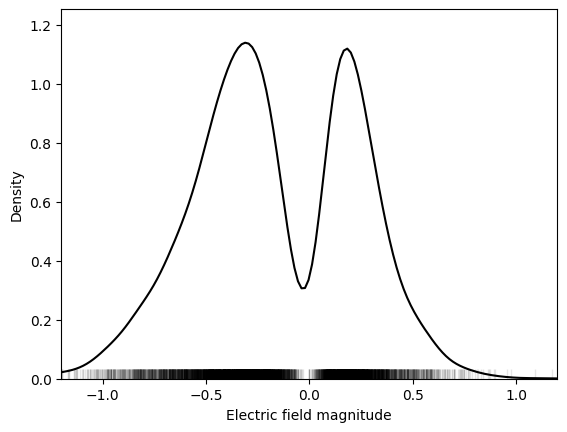

In [20]:
sns.kdeplot(df_charge, x='qt', color="black").set(xlim=(-1.2, 1.2))
sns.rugplot(df_charge, x='qt', color="black", alpha=0.1).set(xlabel = "Electric field magnitude", ylabel = "Density")
#plt.axvline(x=low, color='red', linestyle='--', label='Threshold')
#plt.axvline(x=upp, color='red', linestyle='--', label='Threshold')
#plt.axvline(x=0.309, color='green', linestyle='--', label='Threshold')
#plt.axvline(x=0.291, color='blue', linestyle='--', label='Threshold')
#plt.text(low+0.06, 2, round(low,3).astype("str"), fontsize=10, fontstyle="oblique", color="red", ha="center", va="center")
#plt.text(upp+0.05, 2, round(upp,3).astype("str"), fontsize=10, fontstyle="oblique", color="red", ha="center", va="center")
#plt.text(0.40, 0.5, ''.join(("μ=", str(round(meanq,3)))), fontsize=12, fontweight="bold", color="green", ha="center", va="center")
#plt.text(0.14, 0.5, ''.join(("median=", str(round(medianq,3)))), fontsize=12, fontweight="bold", color="blue", ha="center", va="center")
plt.show()


In [22]:
from scipy.stats import shapiro 
from scipy.stats import kstest
print('Shapiro:', shapiro(df_charge.qt), '\nKolmogorov-Smirnov:', kstest(df_charge['qt'], 'norm'))

Shapiro: ShapiroResult(statistic=0.9822875261306763, pvalue=1.2218668101712207e-26) 
Kolmogorov-Smirnov: KstestResult(statistic=0.2872882098101891, pvalue=0.0, statistic_location=0.389014398457782, statistic_sign=1)


/Users/m872g256/Library/Python/3.9/lib/python/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro test statistic is 0.962 and the p-value is 5.91e-37 (extremely close to zero). Since the $p < 0.05$, we reject the null hypothesis of the Shapiro-Wilk test. This means we have sufficient evidence to say that the **sample data does not come from a normal distribution**.

## Plot by catalytic activity

In [33]:
df_enz = df_charge[df_charge['enzyme'] != 'NON ENZYME']
df_noenz = df_charge[df_charge['enzyme'] == 'NON ENZYME']

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
import numpy as np

test1_mannw = mannwhitneyu(df_enz['qt'], df_noenz['qt'])
test1_kolgo = ks_2samp(df_enz['qt'], df_noenz['qt'])
print('Mann Withney:', test1_mannw, '\nKolmogorov-Smirnov:', test1_kolgo)

Mann Withney: MannwhitneyuResult(statistic=2532406.0, pvalue=3.1403900755053145e-61) 
Kolmogorov-Smirnov: KstestResult(statistic=0.2379806639836997, pvalue=4.530227841910561e-59, statistic_location=-0.3264468317816343, statistic_sign=1)


Significant difference between the two types of proteins ($p < 0.05$)

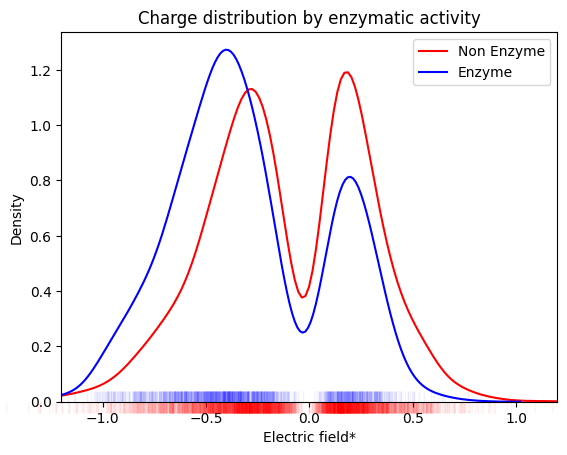

In [28]:
enz_palette = {'Non Enzyme': 'red', 'Enzyme': 'blue'}
fig = sns.kdeplot(data=df_charge, x='qt', hue="enzymatic", common_norm=False, palette = enz_palette)
fig.set(xlim=(-1.2, 1.2), title='Charge distribution by enzymatic activity', 
xlabel="Electric field*", ylabel="Density")
sns.rugplot(data=df_enz, x='qt', color = 'blue', alpha=0.05, height=0.03)
sns.rugplot(data=df_noenz, x='qt', color = "red", alpha=0.05, height=-0.03, clip_on=False)
fig.legend(title = "", labels=['Non Enzyme', 'Enzyme'])
plt.show(fig)

Kolmogorov-Smirnov test statistic is 0.23798 and the p-value is 4.53e-59 (close to zero). Since the $p < 0.05$, we reject the null hypothesis of the Kolmogorov-Smirnov test. This means we have sufficient evidence to say that the **"electric field" distributions are different between ezymatic and non-enzymatic values**.

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('qt ~ enzymatic', data=df_charge).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
enzymatic,38.328960,1.0,266.906388,1.003280e-58
Residual,854.159597,5948.0,NaN,NaN


In [30]:
print("Enzymes mean charge", df_enz['qt'].mean())
print("Non-enzymes mean charge", df_noenz['qt'].mean())

Enzymes mean charge -0.28870433223270686
Non-enzymes mean charge -0.10835917557243897


## Plot by six types of enzymes

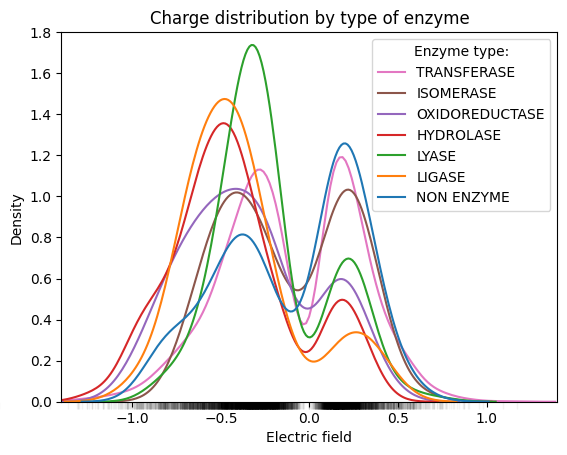

In [39]:
df_charge["enzyme"] = df_charge["enzyme"].astype('category')
labels_enz =['TRANSFERASE', 'ISOMERASE', 'OXIDOREDUCTASE', 'HYDROLASE', 'LYASE', 'LIGASE','NON ENZYME']
df_charge['enzyme'] = df_charge['enzyme'].cat.reorder_categories(labels_enz)
fig = sns.kdeplot(data=df_charge, x='qt', hue="enzyme", common_norm=False)
fig.set(xlim=(-1.4, 1.4), ylim= (0, 1.8), title='Charge distribution by type of enzyme', 
xlabel="Electric field", ylabel="Density")
sns.rugplot(data=df_charge, x='qt', alpha=0.05, height=-0.02, color ='black', clip_on=False)

#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[0]], x='qt', hue="enzyme", alpha=0.8, height=0.08, clip_on=False)
#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[1]], x='qt', hue="enzyme", alpha=0.8, height=0.06, clip_on=False)
#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[2]], x='qt', hue="enzyme", alpha=0.8, height=0.04, clip_on=False)
#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[3]], x='qt', hue="enzyme", alpha=0.8, height=0.02, clip_on=False)
#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[4]], x='qt', hue="enzyme", alpha=0.8, height=-0.06, clip_on=False)
#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[5]], x='qt', hue="enzyme", alpha=0.8, height=-0.04, clip_on=False)
#sns.rugplot(data=df_charge[df_charge['enzyme']==labels_enz[6]], x='qt', hue="enzyme", alpha=0.8, height=-0.02, clip_on=False)
#fig.legend(title = "Enzyme type:", labels = labels_enz)
plt.show(fig)



## Statistics (comparisons)

In [40]:
import itertools
pairs_enz = list(itertools.combinations(labels_enz, 2))

manw_df = []
for pair in pairs_enz:
    enz1 = df_charge[df_charge['enzyme']==pair[0]]
    enz2 = df_charge[df_charge['enzyme']==pair[1]]
    kstest = stats.ks_2samp(enz1['qt'], enz2['qt'])
    row = {'Type1': [pair[0]], 'Type2': [pair[1]], 'p_value': [kstest[1]], 
           'Criteria': ['True' if kstest[1] < 0.05 else "False"]}
    irow = pd.DataFrame(row).T
    manw_df.append(irow)
manw_df = pd.concat(manw_df, axis=1).T
manw_df

,Type1,Type2,p_value,Criteria
0,TRANSFERASE,ISOMERASE,0.0,True
0,TRANSFERASE,OXIDOREDUCTASE,0.0,True
0,TRANSFERASE,HYDROLASE,0.0,True
0,TRANSFERASE,LYASE,0.0,True
0,TRANSFERASE,LIGASE,0.427724,False
0,TRANSFERASE,NON ENZYME,0.013487,True
0,ISOMERASE,OXIDOREDUCTASE,0.0,True
0,ISOMERASE,HYDROLASE,0.237916,False
0,ISOMERASE,LYASE,0.036945,True
0,ISOMERASE,LIGASE,0.000003,True


## By residue

In [64]:
all_res_chrgs = pd.read_csv("../results/charges_residues2.csv")
df_cat = pd.read_excel('../results/catalyticly_identified_sites.xlsx', 'mah2')
df_cat = df_cat[["pdb_name", "enzymen", 'chain_length', 'enzyme_ec']]
df_cat = df_cat.rename(columns={"pdb_name": "pdb", "enzymen": "cat", 
                                'chain_length': 'length', 'enzyme_ec': 'enzyme'}, errors="raise")

df_charge = all_res_chrgs.merge(df_cat.set_index('pdb'), how='left', on='pdb', suffixes=('', '_y'))
df_charge["pdb_uniq"] = df_charge['pdb'].astype(str) + "_" + df_charge['metal_name'].astype(str) + "_" + df_charge['metal_num'].astype(str)
df_charge = df_charge.drop_duplicates(subset=['pdb_uniq'])
df_charge['enzymatic'] = df_charge['enzyme'].apply(lambda x: 'Non Enzyme' if x == 'NON ENZYME' else 'Enzyme')
print(df_charge.shape, all_prot_chrgs.shape)
df_charge.head(2)

(5950, 35) (5950, 9)


,Unnamed: 0,serial,atom_name,altLoc,resName,chainID,resNum,iCode,x,y,z,occupancy,tempFactor,segID,element,res,charge,pdb,metal_name,metal_num,metal_dist,ax,ay,az,ux,uy,uz,qx,qy,qz,cat,length,enzyme,pdb_uniq,enzymatic
0,0,332,C,NaN,ASP,A,24,NaN,-15.72,79.98,91.75,1.0,0.0,NaN,C,ASP,-1.0,13pk_A,MG,422,12.745289,-1.78,11.76,4.58,-0.139659,0.922694,0.359348,-0.010958,-0.072395,-0.028195,1,415,TRANSFERASE,13pk_A_MG_422,Enzyme
68,68,691,C,NaN,PHE,A,43,NaN,58.36,-12.18,23.67,1.0,0.0,NaN,C,PHE,0.0,1a0e_A,CO,491,13.901126,3.02,-0.72,13.55,0.217249,-0.051794,0.974741,0.000000,0.000000,0.000000,1,443,ISOMERASE,1a0e_A_CO_491,Enzyme


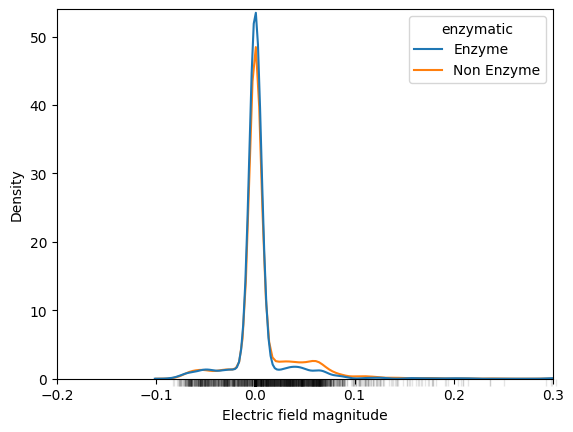

In [83]:
df_charge["enzymatic"] = df_charge["enzymatic"].astype('category')

sns.kdeplot(df_charge, x='qx', color="black", hue="enzymatic", common_norm=False).set(xlim=(-0.2, 0.3))
sns.rugplot(df_charge, x='qx', color="black", alpha=0.1, 
            height=-0.02, clip_on=False).set(xlabel = "Electric field magnitude", ylabel = "Density")
plt.show()

# DRAFTS and TO-DOs


In [84]:
def solvnrg(slvnrg_file):
     with open(slvnrg_file, 'r') as f:
          data = f.read()
     lines = data.split('\n')
     df = pd.DataFrame([line.split() for line in lines if line.startswith('SOLV')],
                    columns=['c1', 'c2', 'c3', 'atom', 'res', 'resn', 'charge', 'solv_nrg'])
     df = df.drop(columns=['c1', 'c2', 'c3'])
     df['atom_id'] = df['res'] + df['resn'] + '_' +df['atom']

     print(df.columns, "\n", df.shape)
solvnrg_path = '../data/7/a/7adh_A/7adh_A_bluues.solv_nrg'
solvnrg(solvnrg_path)

Index(['atom', 'res', 'resn', 'charge', 'solv_nrg', 'atom_id'], dtype='object') 
 (5637, 6)


In [85]:

solvnrg_path = '../data/7/a/7adh_A/7adh_A_bluues.solv_nrg'
solvnrg(solvnrg_path)


Index(['atom', 'res', 'resn', 'charge', 'solv_nrg', 'atom_id'], dtype='object') 
 (5637, 6)


In [91]:
# Obtain solvation energy values for each atom
def nrgsolv_atoms(row_i, dfx):
     atom_mapping = {"H1": "1H", "H2": "2H", "H3": "3H",
          "HB1": "1HB", "HB2": "2HB", "HB3": "3HB",
          "HG1": "1HG", "HG2": "2HG", "HG3": "3HG", 
          "HD1": "1HD", "HD2": "2HD", "HD3": "3HD", 
          "HE1": "1HE", "HE2": "2HE", "HE3": "3HE", 
          "HZ1": "1HZ", "HZ2": "2HZ", "HZ3": "3HZ", 
          "HD11": "1HD1","HD12": "2HD1", "HD13": "3HD1",
          "HD21": "1HD2","HD22": "2HD2", "HD23": "3HD2",
          "HE11": "1HE1","HE12": "2HE1", "HE13": "3HE1",
          "HE21": "1HE2","HE22": "2HE2", "HE23": "3HE2",
          "HG11": "1HG1","HG12": "2HG1", "HG13": "3HG1",
          "HG21": "1HG2","HG22": "2HG2", "HG23": "3HG2",
          "HH11": "1HH1","HH12": "2HH1", "HH13": "3HH1",
          "HH21": "1HH2","HH22": "2HH2", "HH23": "3HH2",
          "HA2": "2HA", "HA3": "3HA"
          }
     atom = dfx.loc[row_i, 'atom']
     if atom in atom_mapping:
          dfx.loc[row_i, 'atom'] = atom_mapping[atom]

def select_res():
     this_struc_file = "%s/%s_Rlx.pdb"%(this_data_dir, this_struc_id)
     df_pdb = get_struc_atom_coords(this_struc_file)
     df_pdb['atom_code'] = df_pdb['resName'] + df_pdb['seqNum'] + '_' + df_pdb['atom_name']
     df_slvnrg = solvnrg(slvnrg_file)
     df_slvnrg["charge"] = df_slvnrg["charge"].astype(float) 

    #merge solvation energy values
     atoms = df_pdb.loc[~df_pdb["atom_name"].isin(METAL_RES_CODES)]
     atoms = atoms.merge(df_slvnrg.set_index('atom_code'), how='left', on='atom_code', suffixes=('', '_y'))
     atoms = atoms.drop('charge', axis=1)
     atoms = atoms.rename(columns={'charge_y': 'charge'})
    
     #Select metal ions 
     metals = df_pdb.loc[df_pdb["atom_name"].isin(METAL_RES_CODES)]
     atoms['metal_name'] = ""
     atoms['metal_num'] = 0
     atoms['metal_dist'] = 10000
     atoms['ax'] = 0
     atoms['ay'] = 0
     atoms['az'] = 0
     atoms['ux'] = 0
     atoms['uy'] = 0
     atoms['uz'] = 0
     df_atoms = []
     if len(metals)>0:
          for mindex, mrow in metals.iterrows():
               for index, row in atoms.iterrows():
                    row['metal_dist'] = math.sqrt((mrow['x']-row['x'])**2 + (mrow['y']-row['y'])**2 + ((mrow['z']-row['z'])**2))
                    row['ax'] = row['x']-mrow['x']; row['ux'] = row['ax']/row['metal_dist']
                    row['ay'] = row['y']-mrow['y']; row['uy'] = row['ay']/row['metal_dist']
                    row['az'] = row['z']-mrow['z']; row['uz'] = row['az']/row['metal_dist']
                    row['metal_name']= mrow['resName']
                    row['metal_num']= mrow['seqNum']
                    irow = pd.DataFrame(row)
                    df_atoms.append(irow)
     df_atoms = pd.concat(df_atoms, axis=1).T
     df_atoms = df_atoms.loc[df_atoms['metal_dist'] <= metal_maxdist].copy().reset_index(drop=True)


def solvnrg(slvnrg_file):
     with open(slvnrg_file, 'r') as f:
          data = f.read()
     lines = data.split('\n')
     df = pd.DataFrame([line.split() for line in lines if line.startswith('SOLV')],
                    columns=['c1', 'c2', 'c3', 'atom', 'res', 'resn', 'charge', 'solv_nrg'])
     df['charge'] = df['charge'].astype(float)
     
     for value in range(len(df)):
          nrgsolv_atoms(value, df)
     df['atom_code'] = df['res'] + df['resn'] + '_' + df['atom']

     return df[['atom', 'res', 'resn', 'atom_code', 'charge']]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks") 
df_plot = chrg_vct_7adh#[chrg_vct_7adh['charge'] != 0]

ax = sns.kdeplot(data=df_plot, x="metal_dist", y="charge", hue='metal_num',
                 shade=True, levels=5, alpha=0.2, cbar=False, shade_lowest=False)
sns.scatterplot(data=df_plot, x="metal_dist", y="charge", hue='metal_num', marker='x', s=8)
sns.rugplot(data=df_plot, x="metal_dist", y="charge", height=0.02, alpha=0.2, clip_on=False)
# Add labels and title
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.xlabel("Distance from Metal site")
plt.ylabel("Charge")
plt.title("Charge")

# Show the plot
plt.show()

In [174]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
get_best_distribution(df_charge.qt)

p value for norm = 6.947803440761368e-55
p value for exponweib = 0.3694555623766078
p value for weibull_max = 1.8207552013825252e-06
p value for weibull_min = 5.072820923560065e-09
p value for pareto = 3.003067900607245e-185
p value for genextreme = 0.07633091016158633
Best fitting distribution: exponweib
Best p value: 0.3694555623766078
Parameters for the best fit: (9.516647213639011, 0.7485955607784374, -0.005834547843008291, 0.012562527373490229)


('exponweib',
 0.3694555623766078,
 (9.516647213639011,
  0.7485955607784374,
  -0.005834547843008291,
  0.012562527373490229))

In [45]:
df_charge.head(20)

NameError: name 'df_charge' is not defined

In [63]:
ks_statistic, p_value = stats.ks_2samp(df_enz["qt"], df_noenz["qt"])
if p_value < 0.05:
    print(f"{round(p_value,5)} The distributions are significantly different.")
else:
    print("No significant difference between the distributions.")

0.03765 The distributions are significantly different.


## POCKET FEATURES

In [46]:
df_pocket = pd.read_csv("../MAHOMES/publication_sites/sites_calculated_features.txt", sep=",")
print(df_pocket.shape)
print(df_pocket.columns)
df_pocket.head(2)

(3985, 486)
Index(['SITE_ID', 'Catalytic', 'MetalCodes', 'MetalAtoms', 'fa_atr_Sum_3.5',
       'fa_rep_Sum_3.5', 'fa_sol_Sum_3.5', 'fa_intra_atr_xover4_Sum_3.5',
       'fa_intra_rep_xover4_Sum_3.5', 'fa_intra_sol_xover4_Sum_3.5',
       ...
       'geom_cn8', 'geom_cn9', 'geom_Filled', 'geom_PartFilled', 'geom_AvgN',
       'geom_AvgO', 'geom_AvgS', 'geom_AvgOther', 'SC_vol_perc', 'Set'],
      dtype='object', length=486)


,SITE_ID,Catalytic,MetalCodes,MetalAtoms,fa_atr_Sum_3.5,fa_rep_Sum_3.5,fa_sol_Sum_3.5,fa_intra_atr_xover4_Sum_3.5,fa_intra_rep_xover4_Sum_3.5,fa_intra_sol_xover4_Sum_3.5,lk_ball_Sum_3.5,lk_ball_iso_Sum_3.5,lk_ball_bridge_Sum_3.5,lk_ball_bridge_uncpl_Sum_3.5,fa_elec_Sum_3.5,fa_intra_elec_Sum_3.5,hbond_sr_bb_Sum_3.5,hbond_bb_sc_Sum_3.5,hbond_sc_Sum_3.5,omega_Sum_3.5,fa_dun_dev_Sum_3.5,fa_dun_rot_Sum_3.5,fa_dun_semi_Sum_3.5,p_aa_pp_Sum_3.5,hxl_tors_Sum_3.5,rama_prepro_Sum_3.5,fa_atr_Mean_3.5,fa_rep_Mean_3.5,fa_sol_Mean_3.5,fa_intra_atr_xover4_Mean_3.5,fa_intra_rep_xover4_Mean_3.5,fa_intra_sol_xover4_Mean_3.5,lk_ball_Mean_3.5,lk_ball_iso_Mean_3.5,lk_ball_bridge_Mean_3.5,lk_ball_bridge_uncpl_Mean_3.5,fa_elec_Mean_3.5,fa_intra_elec_Mean_3.5,hbond_sr_bb_Mean_3.5,hbond_bb_sc_Mean_3.5,hbond_sc_Mean_3.5,omega_Mean_3.5,fa_dun_dev_Mean_3.5,fa_dun_rot_Mean_3.5,fa_dun_semi_Mean_3.5,p_aa_pp_Mean_3.5,hxl_tors_Mean_3.5,rama_prepro_Mean_3.5,BSA_3.5,SASA_3.5,LoopDSSP_3.5,HelixDSSP_3.5,SheetDSSP_3.5,fa_atr_Sum_5,fa_rep_Sum_5,fa_sol_Sum_5,fa_intra_atr_xover4_Sum_5,fa_intra_rep_xover4_Sum_5,fa_intra_sol_xover4_Sum_5,lk_ball_Sum_5,lk_ball_iso_Sum_5,lk_ball_bridge_Sum_5,lk_ball_bridge_uncpl_Sum_5,fa_elec_Sum_5,fa_intra_elec_Sum_5,hbond_sr_bb_Sum_5,hbond_bb_sc_Sum_5,hbond_sc_Sum_5,omega_Sum_5,fa_dun_dev_Sum_5,fa_dun_rot_Sum_5,fa_dun_semi_Sum_5,p_aa_pp_Sum_5,hxl_tors_Sum_5,rama_prepro_Sum_5,fa_atr_Mean_5,fa_rep_Mean_5,fa_sol_Mean_5,fa_intra_atr_xover4_Mean_5,fa_intra_rep_xover4_Mean_5,fa_intra_sol_xover4_Mean_5,lk_ball_Mean_5,lk_ball_iso_Mean_5,lk_ball_bridge_Mean_5,lk_ball_bridge_uncpl_Mean_5,fa_elec_Mean_5,fa_intra_elec_Mean_5,hbond_sr_bb_Mean_5,hbond_bb_sc_Mean_5,hbond_sc_Mean_5,omega_Mean_5,fa_dun_dev_Mean_5,fa_dun_rot_Mean_5,fa_dun_semi_Mean_5,p_aa_pp_Mean_5,hxl_tors_Mean_5,rama_prepro_Mean_5,BSA_5,SASA_5,LoopDSSP_5,HelixDSSP_5,SheetDSSP_5,fa_atr_Sum_7.5,fa_rep_Sum_7.5,fa_sol_Sum_7.5,fa_intra_atr_xover4_Sum_7.5,fa_intra_rep_xover4_Sum_7.5,fa_intra_sol_xover4_Sum_7.5,lk_ball_Sum_7.5,lk_ball_iso_Sum_7.5,lk_ball_bridge_Sum_7.5,lk_ball_bridge_uncpl_Sum_7.5,fa_elec_Sum_7.5,fa_intra_elec_Sum_7.5,hbond_sr_bb_Sum_7.5,hbond_bb_sc_Sum_7.5,hbond_sc_Sum_7.5,omega_Sum_7.5,fa_dun_dev_Sum_7.5,fa_dun_rot_Sum_7.5,fa_dun_semi_Sum_7.5,p_aa_pp_Sum_7.5,hxl_tors_Sum_7.5,rama_prepro_Sum_7.5,fa_atr_Mean_7.5,fa_rep_Mean_7.5,fa_sol_Mean_7.5,fa_intra_atr_xover4_Mean_7.5,fa_intra_rep_xover4_Mean_7.5,fa_intra_sol_xover4_Mean_7.5,lk_ball_Mean_7.5,lk_ball_iso_Mean_7.5,lk_ball_bridge_Mean_7.5,lk_ball_bridge_uncpl_Mean_7.5,fa_elec_Mean_7.5,fa_intra_elec_Mean_7.5,hbond_sr_bb_Mean_7.5,hbond_bb_sc_Mean_7.5,hbond_sc_Mean_7.5,omega_Mean_7.5,fa_dun_dev_Mean_7.5,fa_dun_rot_Mean_7.5,fa_dun_semi_Mean_7.5,p_aa_pp_Mean_7.5,hxl_tors_Mean_7.5,rama_prepro_Mean_7.5,BSA_7.5,SASA_7.5,LoopDSSP_7.5,HelixDSSP_7.5,SheetDSSP_7.5,fa_atr_Sum_9,fa_rep_Sum_9,fa_sol_Sum_9,fa_intra_atr_xover4_Sum_9,fa_intra_rep_xover4_Sum_9,fa_intra_sol_xover4_Sum_9,lk_ball_Sum_9,lk_ball_iso_Sum_9,lk_ball_bridge_Sum_9,lk_ball_bridge_uncpl_Sum_9,fa_elec_Sum_9,fa_intra_elec_Sum_9,hbond_sr_bb_Sum_9,hbond_bb_sc_Sum_9,hbond_sc_Sum_9,omega_Sum_9,fa_dun_dev_Sum_9,fa_dun_rot_Sum_9,fa_dun_semi_Sum_9,p_aa_pp_Sum_9,hxl_tors_Sum_9,rama_prepro_Sum_9,fa_atr_Mean_9,fa_rep_Mean_9,fa_sol_Mean_9,fa_intra_atr_xover4_Mean_9,fa_intra_rep_xover4_Mean_9,fa_intra_sol_xover4_Mean_9,lk_ball_Mean_9,lk_ball_iso_Mean_9,lk_ball_bridge_Mean_9,lk_ball_bridge_uncpl_Mean_9,fa_elec_Mean_9,fa_intra_elec_Mean_9,hbond_sr_bb_Mean_9,hbond_bb_sc_Mean_9,hbond_sc_Mean_9,omega_Mean_9,fa_dun_dev_Mean_9,fa_dun_rot_Mean_9,fa_dun_semi_Mean_9,p_aa_pp_Mean_9,hxl_tors_Mean_9,rama_prepro_Mean_9,BSA_9,SASA_9,LoopDSSP_9,HelixDSSP_9,SheetDSSP_9,fa_atr_Sum_S5,fa_rep_Sum_S5,fa_sol_Sum_S5,fa_intra_atr_xover4_Sum_S5,fa_intra_rep_xover4_Sum_S5,fa_intra_sol_xover4_Sum_S5,lk_ball_Sum_S5,lk_ball_iso_Sum_S5,lk_ball_bridge_Sum_S5,lk_ball_bridge_uncpl_Sum_S5,fa_elec_Sum_S5,fa_intra_elec_Sum_S5,hbond_sr_bb_Sum_S5,hbond_bb_sc_Sum_S5,hbond_sc_Sum_S5,omega_Sum_S5,fa_dun_dev_Sum_S5,fa_dun_rot_

[Text(0.5, 0, 'Largest radii describing the ellipse, Outer Layer'),
 Text(0, 0.5, 'Largest radii describing the ellipse, Inner Layer ')]

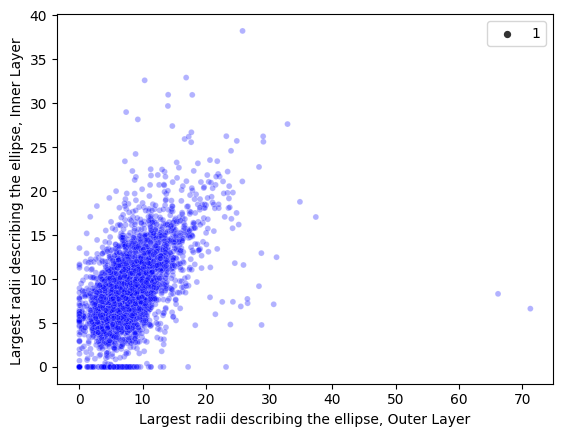

In [23]:

sns.scatterplot(data=df_pocket, x="LongAxLow", y="LongAxHigh", color="blue", alpha=0.3, 
                size=1).set(xlabel = "Largest radii describing the ellipse, Outer Layer", 
                            ylabel = "Largest radii describing the ellipse, Inner Layer ")

### Pocket features   

In [11]:
import os
import sys
import warnings
import math
import sys
import scipy
import subprocess
import pandas as pd
import numpy as np
import scipy.spatial 
from sklearn import cluster

sys.path.insert(0, "%s" % "Pocket/")
import grid_tools as grid
import pocket_lining as lining
import features_ghecom as ghecom

RESOURCE_DIR = "P/"
sys.path.insert(0, "%s" % "Pocket/")
import grid_tools as grid
import pocket_lining as lining

def get_ghecom_pocket_info(filename):
    cluster_cens = subprocess.check_output(["grep", "CA  CEN", filename])
    cluster_cens = cluster_cens.decode("utf-8").strip().split("\n")
    new_cens = []
    for line in cluster_cens:
        new_cens.append( [ line[20:22].strip(), float(line[30:38].strip()), float(line[38:46].strip()), float(line[46:54].strip())] )
    cluster_cens = pd.DataFrame.from_records(new_cens, columns = ["PocketID", "X", "Y", "Z"])
    num_clusters = len(cluster_cens)
    cluster_cens["ClusterNum"] = ""
    cluster_cens["Ngrid"] = 0
    cluster_cens["Volume"] = 0
    cluster_cens["Rinac(A) av"] = 0
    cluster_cens["Rinac(A) mi"] = 0
    cluster_cens["invRvolume(AA)"] = 0
    if len(cluster_cens)==0:
        return(cluster_cens)
    #charmingly, the chain IDs that ghecom outputs don't match the cluster numbers after 9 - the chains start at A and the clusters numbers continue. Wheeeee.
    keep_clusters = cluster_cens.PocketID.values
    good_clusters = []
    for x in keep_clusters:
        try:
            good_clusters.append(str(int(x)))
            cluster_cens.loc[cluster_cens["PocketID"].astype(str) == str(x), "ClusterNum"] = str(int(x))
        except ValueError:
            good_clusters.append(str(ord(x)-55)) #convert the letters to numbers
            cluster_cens.loc[cluster_cens["PocketID"].astype(str) == str(x), "ClusterNum"] = str(ord(x)-55)

    small_clusters = subprocess.check_output( ["grep", "REMARK  CLUSTER_PROPERTY  ", filename ])
    small_clusters = small_clusters.decode("utf-8").strip().split("\n")
    small_clusters = [ x.split() for x in small_clusters[0:num_clusters] ]
    for x in small_clusters:
        #print(x)
        if x[2] in cluster_cens.ClusterNum.values:
            cluster_cens.loc[cluster_cens["ClusterNum"] == x[2], "Ngrid"] = float(x[4])
            cluster_cens.loc[cluster_cens["ClusterNum"] == x[2], "Volume"] = float(x[6])
            cluster_cens.loc[cluster_cens["ClusterNum"] == x[2], "Rinac(A) av"] = float(x[9])
            cluster_cens.loc[cluster_cens["ClusterNum"] == x[2], "Rinac(A) mi"] = float(x[11])
            cluster_cens.loc[cluster_cens["ClusterNum"] == x[2], "invRvolume(AA)"] = float(x[13])
    return(cluster_cens)


def get_clusters_COORDs(grid_file):
    read_data=True
    het_lines = []
    with open(grid_file, "r") as inData:
        for line in inData:
            if line[0:3] == "TER":
                read_data = False
            elif line[0:17] == "REMARK  CLUSTER  ":
                read_data=True
            if read_data == True:
                if line[0:6] == "HETATM":
                    if line[12:16].strip() != "CA":
                        line = line.strip()
                        het_lines.append([ line[20:22].strip(), float(line[30:38].strip()), float(line[38:46].strip()), float(line[46:54].strip()) ])
    grid_coords = pd.DataFrame.from_records(het_lines, columns = ["PocketID", "X", "Y", "Z"])
    return(grid_coords)
                        
def get_closest_pocket_coords(directory, pdb, SITE_center_pt):
    ## read in information from ghecom output for this structure
    ghecom_output_f = "%s/%s_ghecom.pdb"%(directory, pdb)
    
    grid_coords = get_clusters_COORDs(ghecom_output_f)
    pockets_info = get_ghecom_pocket_info(ghecom_output_f)
    
    ## find closest pocket to metal(s)
    grid_coords['dist'] = np.sqrt( (grid_coords.X-SITE_center_pt[0])**2 + (grid_coords.Y-SITE_center_pt[1])**2 + (grid_coords.Z-SITE_center_pt[2])**2)
    closest_dist= grid_coords['dist'].min()
    closest_pocket = grid_coords.loc[grid_coords['dist']==closest_dist,'PocketID'].values[0]
    
    ## find the (maybe) better pocket when multiple are adjacent to site
    adjacent_pockets = grid_coords.loc[grid_coords['dist']<=5,'PocketID'].unique()
    if 1<len(adjacent_pockets):
        ## get the closest "large" pocket when possable
        tmp_pocket_info = pockets_info.loc[pockets_info['PocketID'].isin(adjacent_pockets)].copy()
        tmp_pocket_info = tmp_pocket_info.loc[tmp_pocket_info['Volume']>100]
        if len(tmp_pocket_info['PocketID'].unique())>0:
            grid_coords = grid_coords.loc[grid_coords['PocketID'].isin(tmp_pocket_info['PocketID'].unique())]
            closest_dist= grid_coords['dist'].min()
            closest_pocket = grid_coords.loc[grid_coords['dist']==closest_dist,'PocketID'].values[0]

        
    ## return grid and ghecom info for closest pocket
    return_grid_coords = grid_coords.loc[grid_coords['PocketID']==closest_pocket].copy()
    pocket_info = pockets_info.loc[pockets_info['PocketID']==closest_pocket].copy()
    pocket_info['SITE_pocket_distance_min']=closest_dist
    pocket_info['num_adjacent_pockets']=len(adjacent_pockets)
    return(return_grid_coords.reset_index(drop=True), pocket_info.reset_index(drop=True).iloc[0])


def rotate_pocket_grid(coords_df, centroid1, centroid2):
    #rotate and translate coords to the new centroid1-centroid2 axis
    axis_length = np.linalg.norm(np.asarray(centroid1) - np.asarray(centroid2))
    new_coords = grid.rotate_trans_coords(np.asarray(centroid1), np.asarray(centroid2), np.asarray([0,0,0]), np.asarray([0,0,axis_length]), coords_df[["X", "Y", "Z"]])
    new_coords = pd.DataFrame(np.asarray(new_coords), columns=['X', 'Y', 'Z'])
    return(new_coords)

def calc_distance(p1, p2):
    return( math.sqrt( ((p1[0]-p2[0])*(p1[0]-p2[0])) + ((p1[1]-p2[1])*(p1[1]-p2[1])) + ((p1[2]-p2[2])*(p1[2]-p2[2])) ) )

def calculate_pocket_height_and_depth(coords_df, metal_coords):
    #calculate max distances; after rotation to a z-axis, this is the max - min of the z-direction
    max_z = coords_df.loc[coords_df['Z'].argmax()]
    min_z = coords_df.loc[coords_df['Z'].argmin()]
    #print(max_z)
    #print(min_z)
    height = max_z.Z-min_z.Z
    #print(height)
    depth = calc_distance(max_z, min_z)
    #print(depth)
    metal_hieght = calc_distance(metal_coords, min_z)
    metal_depth = calc_distance(metal_coords, max_z)
    return( height, depth, metal_hieght, metal_depth )


#added 11/3/2021 RF
def calc_pocket_info_plus(pocket, site_center, center_of_mass, pocket_info):
    ## rotate pocket so protein center is oriding and z axis points to pocket center
    pocket_center = np.mean(pocket[["X", "Y", "Z"]], axis = 0)
    pocket_w_site=pd.DataFrame([site_center], columns=['X', 'Y', 'Z'])
    pocket_w_site=pd.concat([pocket_w_site, pocket], ignore_index=True)
    new_pocket_w_site = rotate_pocket_grid(pocket_w_site, center_of_mass, pocket_center)
    new_site_center = new_pocket_w_site.iloc[0].copy()
    new_pocket = new_pocket_w_site.iloc[1:].copy()
    new_pocket_center = np.mean(new_pocket[["X", "Y", "Z"]], axis = 0) # get new pocket center for calculations
    pocket_info['pocket_height'], pocket_info['pocket_depth'], pocket_info['metal_height'], pocket_info['metal_depth'] = calculate_pocket_height_and_depth(new_pocket, new_site_center)
    del pocket_info['X'];del pocket_info['Y'];del pocket_info['Z']; del pocket_info['PocketID']
    return(pocket_info)


#===============

#added 11/16 MWF from CustomModules files
def rotation_matrix(vector1, origin):
    #vector1 should be a vector between two points; origin should be the vector to which vector1 is being moved
    vector1 = vector1/np.linalg.norm(vector1)
    origin = origin/np.linalg.norm(origin)
    v = np.cross(vector1, origin)
    c = np.dot(vector1, origin)
    s = np.linalg.norm(v)
    I = np.identity(3)
    k = np.matrix([(0, -v[2], v[1]), (v[2], 0, -v[0]), (-v[1], v[0], 0)])#.reshape(3,3)
    #print(k)
    r = I + k + np.matmul(k,k) * ((1 -c)/(s**2))
    return(r)

#added 11/16 MWF from CustomModules files
def translation(new_point, origin):
    return (new_point - origin)

#added 11/16 MWF from CustomModules files
def rotate_trans_coords(a, b, a_orig, b_orig, res_coord_array):
    #a, b are current points; a_orig, b_orig are where they should move to; res_coord_array contains coordinates to be moved
    #print(a_orig - b_orig)
    rot_mat = rotation_matrix(a-b, a_orig-b_orig)
    #print(rot_mat)
    trans_vect = translation(np.asarray(np.dot(rot_mat, a))[0], a_orig )
    #print(trans_vect)
    matrix_coords = np.transpose(res_coord_array)
    matrix_rot = np.matmul(rot_mat, matrix_coords)
    #print(matrix_rot)
    rotated_coords = np.transpose(matrix_rot)
    #print(rotated_coords)
    rotated_coords = rotated_coords - trans_vect
    return(rotated_coords) #returns a matrix of n by 3 of the translated/rotated vectors

#following functions blatantly copied from http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    #print("D:", D)
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2
    C[1,1] = -1
    #print("S:", S)
    #print("C:", C)
    #print( np.linalg.pinv(S) )
    E, V =  np.linalg.eig(np.dot(np.linalg.pinv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else: 
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    #print(up, down1, down2)
    res1=np.sqrt(np.absolute(up/down1)) #added absolute value 1-10-18 MWF
    res2=np.sqrt(np.absolute(up/down2)) #added absolute value 1-10-18 MWF
    #print(res1, res2)
    return np.array([res1, res2])

#added 11/16 MWF

#given an array of points that have been pre-rotated to x,y,z and a pair of z-boundaries in that array
#return features describing that slice of points
#   farthest_point is the max of the distance between all the points in the slice
#   pocket_area is the area of the convex hull; in otherwords, the approx cross-sectional area of the slice
#   pocket_offset is how far the center of the ellipse is from the origin where the points have been rotated to
#   long/short_axis is the ellipse dimensions
def calc_slice_features(pocket_array, z_depth, interval = 1.4):
    upper_slice_boundary = z_depth + interval
    lower_slice_boundary = z_depth - interval
    #the z-coordinate is not considered for any of these calculations; the slice of points is flattened into just x,y space
    pocket_slice = pocket_array[ (pocket_array[:,2] <= upper_slice_boundary) & (pocket_array[:,2] >= lower_slice_boundary)]
    #print(pocket_slice)
    if len(pocket_slice) > 0:
        all_dist = scipy.spatial.distance.cdist(pocket_slice[:,0:2], pocket_slice[:,0:2])
        farthest_point = np.max(all_dist) 
        #print("farthest:", farthest_point)
        if len(pocket_slice) > 2:
            #calculate the area of the convex hull that encloses the points
            hull = scipy.spatial.ConvexHull(pocket_slice[:,0:2], qhull_options="QJ")
            #print(hull)
            #fit an ellipse to the hull points
            pocket_area = hull.area
            #print("pocket area", pocket_area)
            a = fitEllipse(hull.points[hull.vertices][:,0], hull.points[hull.vertices][:,1])
            center = ellipse_center(a)
            pocket_offset = scipy.spatial.distance.cdist([[0,0]], [center])
            phi = ellipse_angle_of_rotation(a)
            axes = ellipse_axis_length(a)
            long_axis = max(axes)
            short_axis = min(axes)
            #print(long_axis, short_axis)
            return [float(farthest_point), float(pocket_area), float(pocket_offset[0][0]), float(long_axis), float(short_axis)]
        else:
            return[farthest_point, 0, 0, 0, 0]
    else:
        return [0,0,0,0,0]

##Takes in a pocket pdb file and parses down to the relevant grid points    
def process_pocket(pocket_file):
    tp = []
    tpb = []
    tpe = []
    tps = []
    stp = []
    sts = []
    stb = []
    ste = []
    ts = []
    whole_pocket = []

    ##Read in the pocket PDB file
    ##Place the points into the respective lists. 
    ##TP should be key target. but, you can often have issues in pits so stp is useful too. 
    with open(pocket_file, "r") as pocketPDB:
        for entry in pocketPDB:
            if (entry[0:6] == "ATOM  "):
                m_id = int(entry[8:11])
                x = float(entry[31:38])
                y = float(entry[39:46]) 
                z = float(entry[47:54])
                resn = entry[13:16].strip() ##???
                t = np.array([x, y, z])

                if (resn == "PR"): #protein
                    pass
                elif (resn == "TP"): #target pocket
                    tp.append(t)
                    whole_pocket.append(t)
                elif (resn == "TPB"): #target pocket buried
                    tpb.append(t)
                    whole_pocket.append(t)
                elif (resn == "TPE"): #target pocket edge
                    tpe.append(t)
                    #whole_pocket.append(t)
                elif (resn == "TPS"): #target pocket surface
                    tps.append(t)
                    whole_pocket.append(t)
                elif (resn == "STP"): #small pocket
                    stp.append(t)
                    whole_pocket.append(t)
                elif (resn == "STS"): #small pocket surface
                    sts.append(t)
                    whole_pocket.append(t)
                elif (resn == "STB"): #small pocket buried
                    stb.append(t)
                    whole_pocket.append(t)
                elif (resn == "TS"): #target surface? 
                    ts.append(t)
                    whole_pocket.append(t)
                elif (resn == "STE"): #small pocket edge
                    ste.append(t)
                    #whole_pocket.append(t)
    return [tp, tpb, tpe, tps, stp, sts, stb, ts, whole_pocket] #each of these is a list of np arrays; these can be converted to an n by 3 array with np.asarray(X)

def get_vectors(pocket_defs, origin, closest_res):
    #pocket_defs should be a n by 3 numpy array
    #origin should be a [x, y, z] array
    #closest res is also in the form of an [x, y, z] array

    #Find average of subset of points selected to be the pocket opening, i.e. TP/STP residues in grid file
    ##Average of all points in pocket_defs 
    z_target = np.average(pocket_defs, axis = 0)
    #print(z_target)
    #Get Z
    z = z_target - origin
    z /= np.linalg.norm(z)
    #Get X
    x = closest_res - origin
    #print(x)
    #get the orthogonal vector from x
    x -= x.dot(z) * z

    ##Now the cross product to get the Y vector
    y = np.cross(x, z)

    #returns unit vectors of x, y, z
    return [x, y, z, z_target - origin]

def vectors_from_pdb(pocket_grid_name, metal_ion_center, m_closest_residue):
    pocket_defs = process_pocket(pocket_grid_name)
    endpoints = pocket_defs[0] + pocket_defs[4]
    vecs = get_vectors(np.asarray(endpoints), metal_ion_center, m_closest_residue)
 
    return vecs

#added 11-20-18 MWF
def calc_pocket_features(pdb_id, site_id, pocket, origin, nearest_res_coords, center_of_mass, directory):
    
    feature_labels = ["farPt", "PocketArea", "Offset", "LongAx", "ShortAx"]
    labels1 = [x+"Low" for x in feature_labels]
    labels2 = [x+"Mid" for x in feature_labels]
    labels3 = [x+"High" for x in feature_labels]
    all_labels = ["SEPocket", "Depth", "Vol", "LongPath"] + labels1 + labels2 + labels3

    target_pocket = pocket[0] + pocket[4] #TP and STP residue codes in pocket pdb - target pocket
    #print(target_pocket)
    if len(target_pocket) == 0:
        if len(pocket[3] + pocket[5]) > 0: #use TPS/STS - pocket surface
            target_pocket = pocket[3] + pocket[5]
            pocket_type = 2
            #print("USING TPS residues")
        #print(len(pocket[1]))
        elif len(pocket[1]) > 0: #if we have no TP or STP residues, use the TPB ones instead
            pocket_type = 1
            target_pocket = farthest_residue(center_of_mass, pocket[1]) #rather than the average of all of the TPB, 
            #print("USING TPB residues from C.O.M.", target_pocket)
        else:
            print("NO SURFACE POCKET", pdb_id, site_id)
            if len(pocket[7]) > 0 :
                return(all_labels, [0] * 19)
            else:
                return(all_labels, [4] + [0]*18 )
    else:
        pocket_type = 3
        
    vectors = get_vectors(np.asarray(target_pocket), origin, nearest_res_coords)
    #print(vectors)
    depth_in_pocket = np.linalg.norm(vectors[-1])
    volume = subprocess.check_output(["sed", "1q;d", "%s/%s_Vol.txt"%(directory, site_id)] )
    #print(volume)
    volume = volume.decode("utf-8").strip().split("\n")[0].split()[-1]
    volume = float(volume) #volume of pocket from pocket_grid
    longest_path_out = scipy.spatial.distance.cdist([vectors[-1]], [origin], "cityblock" )[0][0] #if you traverse a grid from origin to the target pocket, how far is it?

    #vectors[2] is the unit z-axis as returned from get_vectors, [0,0,0] is the origin for this z-axis; the pocket array must be pre-translated
    rotated_pocket = np.asarray(rotate_trans_coords(np.array([0,0,0]), vectors[2], np.array([0, 0, 0]), np.array([0,0,1]), np.asarray(pocket[-1])-origin))

    #the pocket grid is currently done on 0.5A intervals; 
    #an interval of 1.4 is approximately the distance between 3 stacked grid points on the diagonal; 
    #a slice containing +- an interval should capture a resonable collection of points
    middle_features = calc_slice_features(rotated_pocket, depth_in_pocket/2)
    upper_features = calc_slice_features(rotated_pocket, depth_in_pocket)
    lower_features = calc_slice_features(rotated_pocket, 0)
    
    this_SITE_features = [pocket_type, depth_in_pocket, volume, longest_path_out]
    this_SITE_features.extend(lower_features)
    this_SITE_features.extend(middle_features)
    this_SITE_features.extend(upper_features)
    
    #solvent-exposed pocket, depth, vol, long_path, [farthest_point, pocket_area, pocket_offset[0][0], long_axis, short_axis] for low/mid/upper
    return(all_labels, this_SITE_features)
    
def nearest_neigh(site_center, metal_resIDs, myProtein):
    distances, near_res = myProtein.KDTree.query(site_center, k = 40, distance_upper_bound = 10)
    distances = [x for x in distances if np.isinf(x) == False]
    if len(distances) == 0:
        return("NA")
        
    near_res = near_res[0:len(distances)]
    new_res_ids = [myProtein.Coords_index[x] for x in near_res]
    new_res_ids = sorted(set(new_res_ids), key = new_res_ids.index)
    new_res_ids = [x for x in new_res_ids if x not in metal_resIDs]
    #print(new_res_ids)
    if len(new_res_ids) == 0:
        return("NotBound")
    else:
        for x in range(0, len(new_res_ids)):
            this_res = myProtein.residues[ myProtein.res_nums.index(new_res_ids[x]) ]
            #print(new_res_ids[x], this_res.resnum, this_res.type)
            if this_res.type == "protein":
                return(new_res_ids[x])
        return("NotBound")

def closest_residue(origin, residue_list):
    distances = residue_list - origin
    nearest_neighbor = residue_list[np.argmin( np.sum(distances**2, axis=1))] #return the row that corresponds to the minimum distance
    return nearest_neighbor
    
def farthest_residue(origin, residue_list):
    distances = residue_list - origin
    nearest_neighbor = residue_list[np.argmax( np.sum(distances**2, axis=1))] #return the row that corresponds to the minimum distance
    return nearest_neighbor



#adjusted version for using ghecom pocket
def calc_pocket_features_ghecom(pocket, origin, metal_res, this_protein, res_nums):
    site_neigh = nearest_neigh(origin, metal_res, this_protein)
    nearest_neigh_coords = closest_residue(origin, this_protein.residues[ res_nums.index(int(site_neigh[:-1])) ].Coords)

    feature_labels = ["farPt", "PocketArea", "Offset", "LongAx", "ShortAx"]
    labels1 = [x+"Low" for x in feature_labels]
    labels2 = [x+"Mid" for x in feature_labels]
    labels3 = [x+"High" for x in feature_labels]
    all_labels = ["Depth", "Vol", "LongPath"] + labels1 + labels2 + labels3

    target_pocket = pocket
        
    vectors = get_vectors(np.asarray(target_pocket), origin, nearest_neigh_coords)
    #print(vectors)
    depth_in_pocket = np.linalg.norm(vectors[-1])
    
    volume = len(pocket)*0.512
    longest_path_out = scipy.spatial.distance.cdist([vectors[-1]], [origin], "cityblock" )[0][0] #if you traverse a grid from origin to the target pocket, how far is it?

    #vectors[2] is the unit z-axis as returned from get_vectors, [0,0,0] is the origin for this z-axis; the pocket array must be pre-translated
    rotated_pocket = np.asarray(rotate_trans_coords(np.array([0,0,0]), vectors[2], np.array([0, 0, 0]), np.array([0,0,1]), np.asarray(pocket)-origin))

    #the pocket grid is currently done on 0.5A intervals; 
    #an interval of 1.4 is approximately the distance between 3 stacked grid points on the diagonal; 
    #a slice containing +- an interval should capture a resonable collection of points
    middle_features = calc_slice_features(rotated_pocket, depth_in_pocket/2)
    upper_features = calc_slice_features(rotated_pocket, depth_in_pocket)
    lower_features = calc_slice_features(rotated_pocket, 0)
    
    this_SITE_features = [depth_in_pocket, volume, longest_path_out]
    this_SITE_features.extend(lower_features)
    this_SITE_features.extend(middle_features)
    this_SITE_features.extend(upper_features)
    
    #solvent-exposed pocket, depth, vol, long_path, [farthest_point, pocket_area, pocket_offset[0][0], long_axis, short_axis] for low/mid/upper
    return(all_labels, this_SITE_features)

#=======================
eisenburg_hp = {"A":  0.620, "R": -2.530, "N": -0.780, "D": -0.900, "C":  0.290, "Q": -0.850, "E": -0.740, "G":  0.480, "H": -0.400,  "I":  1.380, 
"L":  1.060, "K": -1.500, "M":  0.640, "F":  1.190, "P":  0.120, "S": -0.180, "T": -0.050, "W":  0.810, "Y":  0.260, "V":  1.080, "X": 0}

kyte_doo_hp = {"A":  1.800, "R": -4.5, "N": -3.5, "D": -3.5, "C":  2.5, "Q": -3.5, "E": -3.5, "G":  -0.4, "H": -3.2,  "I":  4.5, 
"L":  3.8, "K": -3.9, "M":  1.9, "F":  2.8, "P":  -1.6, "S": -0.8, "T": -0.7, "W":  -0.9, "Y":  -1.2, "V":  4.2, "X": 0}

metal_size = {np.nan: 0,
         'MO':1, 'MOO':5, '4MO' : 1,'6MO' :1,'MOS': 4,
         'MG': 1,'3NI':1,'NI' : 1, 'ZN': 1,'MGF': 4,'MN3' : 1,'MN' : 1,'CO': 1,
         'OFE': 2, 'FE2': 1,'FEO': 3, 'FE' : 1,'FES': 4,
         'CU': 1, 'C2O' :3, 'CUA' : 2, 'CU1': 1,
         }

vdw_vols = {"G":48,"A":67,"S":73,"C":86,"P":90,"D":91,"T":93,"N":96,"V":105,
    "E":109,"Q":114,"H":118,"I":124,"L":124,"M":124,"K":135,"F":135,"Y":141,"R":148,"W":163,"X":0}
    

#added 12-18-18 MWF for clustering pocket points to identify the ones that are actually close to SITE center for identifying the residues lining the pocket
def cluster_grid_points(pocket_list):
    dbscan = cluster.DBSCAN(eps = 0.9)
    prediction = dbscan.fit_predict(pocket_list)
    return(prediction)

def graph_grid(pocket_list, prediction, near_neigh):
    colors = np.array(["black", "red", "green", "yellow", "orange", "purple"])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(near_neigh[0], near_neigh[1], near_neigh[2], color="blue")
    ax.scatter3D(pocket_list[:,0], pocket_list[:,1], pocket_list[:,2], color=colors[prediction].tolist())
    plt.show()

def get_nearby_grid(pocket_list, cluster_prediction, SITE_center, cutoff):
    #cutoff should be in A
    grid_distances = np.sum((pocket_list - SITE_center)**2, axis=1)# calculate all distances between grid points and SITE center                
    metal_cluster = cluster_prediction[ grid_distances < float(cutoff)**2 ] #keep any cluster with a point within cutoff**2 of the site center (the distances are still squared)
    metal_cluster = sorted(set(metal_cluster))
    pocket_list = pocket_list[ np.in1d(cluster_prediction, metal_cluster) ]
    return(pocket_list)
    
def id_pocket_lining(grid_points, myProtein, cutoff=2.5):
    max_len=500
    if len(myProtein.residues) < max_len:
        all_dist = scipy.spatial.distance.cdist(myProtein.Coords, grid_points) #calculate all pairwise distances
        #print(np.amin(all_dist), np.amax(all_dist))
        pocket_liner = np.asarray(myProtein.Coords_index)[np.any(all_dist <= float(cutoff), axis = 1)].tolist() #keep the residues where at least one atom is within the cutoff distance
    # these PDBs are require to much memory, so they will be handled with a slower loop
    else:
        pocket_liner=[]
        for res in myProtein.residues:
            all_dist = scipy.spatial.distance.cdist(res.Coords, grid_points)        
            if np.any(all_dist <= float(cutoff)):
                res_num=str(res.resnum) + res.chain
                pocket_liner.append(res_num)

    pocket_liner = sorted(set(pocket_liner)) 
    #print(pocket_liner)
    return(pocket_liner)

def split_pocket_lining(pocket_lining_list, pocket_points, myProtein, cutoff = 2.2):
    backbone_res = []
    sidechain_res = []
    backbone_names = []
    sidechain_names = []
    #print(pocket_lining_list)
    #print(pocket_points)
    
    for entry in pocket_lining_list:
        this_res = myProtein.residues[ myProtein.res_nums.index(entry) ]
        #print(this_res.name, this_res.resnum)#, this_res.Atoms)
        if this_res.name in metal_size.keys():
            continue
        keep_atoms = this_res.Atoms.copy()
        if this_res.name != "GLY":
            keep_atoms = [x for x in keep_atoms if x not in ["H", "HA"]] #don't consider the hydrogens on the backbone
        this_dist = scipy.spatial.distance.cdist(this_res.Coords[ np.where(np.in1d(this_res.Atoms, keep_atoms)) ], pocket_points) #distance between all non-H coords of residue and the pocket grid points
        #print(this_dist.shape)
        if len(keep_atoms) < 5:
            continue
        closest_atoms = np.min(this_dist, axis = 1) #minimum distances for each atom
        min_bbone = np.min(closest_atoms[:4]) #minimum in first four atoms - C N CA O
        max_sc = np.min(closest_atoms[4:]) #minimum distance in sidechain
        if max_sc <= min_bbone: #sidechain is closer
            sidechain_res.append(entry) 
            sidechain_names.append(this_res.onelet)
            #print(this_res.onelet)
        elif max_sc < cutoff: #sidechain is pretty darn close anyways
            sidechain_res.append(entry)
            sidechain_names.append(this_res.onelet)
            #print(this_res.onelet)
        else: #otherwise, only backbone lines pocket
            backbone_res.append(entry)
            backbone_names.append(this_res.onelet)
            #print(this_res.onelet)
    #print(sidechain_names)
    #print(backbone_names)            
    return(backbone_res, backbone_names, sidechain_res, sidechain_names)

def calc_lining_features(bb_list, sc_list, myProtein):
    these_labels = ["in_pocket", "num_pocket_bb", "num_pocket_sc", "avg_eisen_hp", "min_eisen", "max_eisen", "skew_eisen", "std_dev_eisen", "avg_kyte_hp", "min_kyte", "max_kyte", "skew_kyte", "std_dev_kyte", "occ_vol"]
    if len(sc_list) > 0:
        eisenburg = np.asarray([eisenburg_hp[x] for x in sc_list])
        kyte = np.asarray([kyte_doo_hp[x] for x in sc_list])
        occ_vol = np.asarray([vdw_vols[x] for x in sc_list])
        eisen_descrip = scipy.stats.describe(eisenburg)
        kyte_descrip = scipy.stats.describe(kyte)
        these_features = [1, (len(bb_list) + len(sc_list)), len(sc_list), eisen_descrip.mean, eisen_descrip.minmax[0], eisen_descrip.minmax[1], eisen_descrip.skewness, np.sqrt(eisen_descrip.variance), 
            kyte_descrip.mean, kyte_descrip.minmax[0], kyte_descrip.minmax[1], kyte_descrip.skewness, np.sqrt(kyte_descrip.variance), sum(occ_vol)]
    else:
        these_features = [[0] * len(these_labels)]
    #print(these_features)
    return(these_labels, these_features)
    
    
#===================

def get_pocket_lining_features(this_data_dir, site, this_protein, res_nums):
    pdb = site.metal_atoms[0].struc_id
    metal_res=[]
    for metal in site.metal_atoms:
        metal_res.append(str(int(metal.seqID))+metal.chainID)

    SITE_center_pt = site.get_center()
    whole_pocket, pocket_info = ghecom.get_closest_pocket_coords(this_data_dir, pdb, SITE_center_pt)
    pocket_coords = whole_pocket[['X','Y','Z']]
    
    if len(whole_pocket) > 0:
        pocket_lining_res = lining.id_pocket_lining(pocket_coords, this_protein, cutoff=3)
        pocket_lining_res = set(pocket_lining_res).difference(metal_res)
        #print(pocket_lining_res, res_nums)
        
        pocket_lining_res = [x for x in pocket_lining_res if this_protein.residues[ this_protein.res_nums.index(x) ].type == "protein"]
        bb, bb_names, sc, sc_names = lining.split_pocket_lining(pocket_lining_res, pocket_coords, this_protein, cutoff = 2.2)
        #print(bb, bb_names, sc, sc_names)         
    else:
        print("No pocket", pdb, site.SITE_ID)
        bb_names = []
        sc_names = []
    
    labels, pocket_lining = lining.calc_lining_features(bb_names, sc_names, this_protein)
    pocket_lining = pd.DataFrame(pocket_lining, index=labels) 
    
    center_of_mass = np.mean(this_protein.Coords, axis = 0)
    dist_to_center = np.linalg.norm(SITE_center_pt - center_of_mass)
    labels, pocket_shape = grid.calc_pocket_features_ghecom(pocket_coords, SITE_center_pt, metal_res, this_protein, res_nums)
    labels.extend(["SITEDistCenter", "SITEDistNormCenter"])
    max_dist_to_center = np.sqrt(np.max( np.sum( (this_protein.Coords - dist_to_center)**2, axis = 1) ))
    pocket_shape.extend([dist_to_center, dist_to_center/max_dist_to_center])   
    pocket_shape = pd.DataFrame(pocket_shape, index=labels)

    ## add lining features that require Vol from pocket shape
    pocket_lining.loc["NoSC_vol"] = pocket_shape.loc["Vol"][0] + pocket_lining.loc["occ_vol"][0] 
    pocket_lining.loc["SC_vol_perc"] = pocket_lining.loc["occ_vol"][0] / pocket_lining.loc["NoSC_vol"][0]
    
    pocket_info = ghecom.calc_pocket_info_plus(pocket_coords, SITE_center_pt, center_of_mass, pocket_info)
    return(pocket_shape, pocket_lining, pocket_info)

## if ghecom can't find any pockets, the above willl fail and all (?) pocket features should be 0 in such an event
def get_empty_pocket_lining_features():
    pocket_shape_cols = ['Depth', 'Vol', 'LongPath', "SITEDistCenter", "SITEDistNormCenter",
    'farPtLow', 'PocketAreaLow', 'OffsetLow','LongAxLow', 'ShortAxLow',
    'farPtMid', 'PocketAreaMid','OffsetMid', 'LongAxMid', 'ShortAxMid',
    'farPtHigh','PocketAreaHigh', 'OffsetHigh', 'LongAxHigh', 'ShortAxHigh']
    pocket_lining_cols = ['in_pocket', 'num_pocket_bb', 'num_pocket_sc',
     'avg_eisen_hp','min_eisen', 'max_eisen', 'skew_eisen', 'std_dev_eisen',
     'avg_kyte_hp', 'min_kyte', 'max_kyte', 'skew_kyte','std_dev_kyte',
      'occ_vol', 'NoSC_vol', 'SC_vol_perc']
    pocket_info_cols = ['ClusterNum','Ngrid','Volume'
                   ,'Rinac(A) av','Rinac(A) mi','invRvolume(AA)'
                   ,'pocket_height','pocket_depth'
                   ,'metal_height','metal_depth'
                   ,'SITE_pocket_distance_min','num_adjacent_pockets'
                  ]
    pocket_shape = pd.DataFrame(0, columns=[0], index=pocket_shape_cols)
    pocket_lining = pd.DataFrame(0, columns=[0], index=pocket_lining_cols)
    pocket_info = pd.Series(0, index=pocket_info_cols)

    return(pocket_shape, pocket_lining, pocket_info)

def pocket_lining_features(struc_dir, site, this_protein, res_nums):
    #try:
    pocket_shape, pocket_lining, pocket_info = get_pocket_lining_features(struc_dir, site, this_protein, res_nums)
    #except:
    #    pocket_shape, pocket_lining, pocket_info = get_empty_pocket_lining_features()
    ## add prefixes for future domain handling and analysis
    pocket_shape = pocket_shape.T.add_prefix("pkt_shape_").T # double transform because rows can't prefix?
    pocket_lining = pocket_lining.T.add_prefix("pkt_lining_").T # double transform because rows can't prefix?
    pocket_info = pocket_info.add_prefix("pkt_info_")
    return(pocket_shape, pocket_lining, pocket_info)


In [12]:
def get_clusters_COORDs(grid_file):
    read_data=True
    het_lines = []
    with open(grid_file, "r") as inData:
        for line in inData:
            if line[0:3] == "TER":
                read_data = False
            elif line[0:17] == "REMARK  CLUSTER  ":
                read_data=True
            if read_data == True:
                if line[0:6] == "HETATM":
                    if line[12:16].strip() != "CA":
                        line = line.strip()
                        het_lines.append([ line[20:22].strip(), float(line[30:38].strip()), float(line[38:46].strip()), float(line[46:54].strip()) ])
    grid_coords = pd.DataFrame.from_records(het_lines, columns = ["PocketID", "X", "Y", "Z"])
    return(grid_coords)

In [13]:

get_clusters_COORDs(dirpath)

,PocketID,X,Y,Z


In [1]:
dirpath = '../data/7/a/7adh_A/7adh_A_Rlx.pdb'
this_data_dir = '../data/7/a/7adh_A/7adh_A_Rlx.pdb'
site = "site"
this_protein = "7adh_A"
res_nums = "ZN"
get_pocket_lining_features(this_data_dir, site, this_protein, res_nums)

NameError: name 'get_pocket_lining_features' is not defined